In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import gymnasium as gym
from gymnasium import spaces


# --- ŚRODOWISKO ---
class DartThrowEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_throw_range = 1.5
        self.max_steps = 1
        self.current_step = 0

        self.action_space = spaces.Box(
            low=np.array([-self.max_throw_range, -self.max_throw_range]),
            high=np.array([self.max_throw_range, self.max_throw_range]),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # proporcjonalne strefy
        self.radius_10 = self.max_throw_range * (1 / 5)  # 0.3
        self.radius_5 = self.max_throw_range * (2 / 5)   # 0.6
        self.radius_1 = self.max_throw_range * (4 / 5)   # 1.2

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        self.current_step += 1
        done = True

        x, y = action
        dist = np.sqrt(x ** 2 + y ** 2)

        if dist < self.radius_10:
            reward = 10.0
        elif dist < self.radius_5:
            reward = 5.0
        elif dist < self.radius_1:
            reward = 1.0
        else:
            reward = -10.0

        obs = np.array([0.0], dtype=np.float32)
        return obs, reward, done, False, {}

In [6]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from pprint import pprint
import matplotlib.pyplot as plt

action_grid = np.array([[x, y] for x in np.linspace(-1, 1, 100)
                               for y in np.linspace(-1, 1, 100)])
action_size = len(action_grid)

def train_dqn(env_class, params, episodes=400, throws_per_episode=20, verbose=False):
    env = env_class()
    state_size = env.observation_space.shape[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    q_network = QNetwork(state_size, action_size).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=params['learning_rate'])
    loss_fn = nn.MSELoss()

    epsilon = params['epsilon_start']
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        total_reward = 0

        for step in range(throws_per_episode):
            if np.random.rand() < epsilon:
                action_idx = np.random.randint(action_size)
            else:
                with torch.no_grad():
                    q_values = q_network(state_tensor)
                    action_idx = torch.argmax(q_values).item()

            action = action_grid[action_idx]
            next_state, reward, done, _, _ = env.step(action)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)

            with torch.no_grad():
                next_q_values = q_network(next_state_tensor)
                max_next_q = torch.max(next_q_values)
                target_q = reward + params['discount_factor'] * max_next_q

            predicted_q = q_network(state_tensor)[action_idx]
            loss = loss_fn(predicted_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state_tensor = next_state_tensor
            total_reward += reward

        epsilon = max(params['epsilon_min'], epsilon * params['epsilon_decay'])
        rewards.append(total_reward)

        if verbose and episode % 50 == 0:
            print(f"Ep {episode} - Reward: {total_reward:.2f}")

    env.close()
    return np.mean(rewards)

param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],
    'discount_factor': [0.9, 0.99],
    'epsilon_start': [1.0],
    'epsilon_min': [0.05],
    'epsilon_decay': [0.95, 0.99],
}

best_params = None
best_score = -float('inf')
scores = []

print("Rozpoczynam wyszukiwanie najlepszych hiperparametrów...\n")

for params in ParameterGrid(param_grid):
    print(f"Testuję: {params}")
    score = train_dqn(DartThrowEnv, params)
    scores.append((params, score))
    print(f" → Średnia suma nagród: {score:.2f}")
    if score > best_score:
        best_score = score
        best_params = params

print("\nTestowane kombinacje:")
pprint([x[0] for x in scores])

print(f"\nNajlepsze parametry: {best_params}")
print(f"Najlepszy wynik (średnia nagród): {best_score:.2f}")


Rozpoczynam wyszukiwanie najlepszych hiperparametrów...

Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.95, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.001}


/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


 → Średnia suma nagród: 93.83
Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.95, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.005}


/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ukostuch/Documents/SEM6/INTELIGENCJA_OBLICZENIOWA/LAB4/sklearn-env/lib/python3.13/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


 → Średnia suma nagród: 21.55
Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.95, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.01}
 → Średnia suma nagród: 130.61
Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.99, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.001}
 → Średnia suma nagród: 24.54
Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.99, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.005}
 → Średnia suma nagród: 84.10
Testuję: {'discount_factor': 0.9, 'epsilon_decay': 0.99, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.01}
 → Średnia suma nagród: 147.12
Testuję: {'discount_factor': 0.99, 'epsilon_decay': 0.95, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.001}
 → Średnia suma nagród: 93.93
Testuję: {'discount_factor': 0.99, 'epsilon_decay': 0.95, 'epsilon_min': 0.05, 'epsilon_start': 1.0, 'learning_rate': 0.005}
 → Średnia suma nagród: 21.11
Testuję: {'discount_factor': 0.99, 'epsilon_

Epizod 0, suma nagród: 41.0
Epizod 50, suma nagród: 59.0
Epizod 100, suma nagród: 122.0
Epizod 150, suma nagród: 146.0
Epizod 200, suma nagród: 177.0
Epizod 250, suma nagród: 191.0
Epizod 300, suma nagród: 200.0
Epizod 350, suma nagród: 200.0


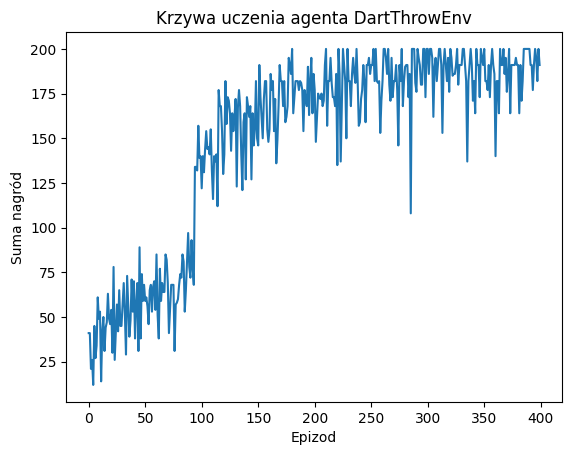

In [12]:
#uczenie z wykresem
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# --- WIZUALIZACJA ---
def visualize_dartboard_cv2(env, throws=[], wait_time=1000):
    size = 500
    center = size // 2
    scale = center / env.max_throw_range
    img = np.ones((size, size, 3), dtype=np.uint8) * 255

    def draw_circle(radius, color):
        r = int(radius * scale)
        cv2.circle(img, (center, center), r, color, -1)

    draw_circle(env.radius_1, (200, 255, 200))   # jasnozielony (1 pkt)
    draw_circle(env.radius_5, (0, 255, 255))     # żółty (5 pkt)
    draw_circle(env.radius_10, (0, 255, 0))      # zielony (10 pkt)

    for throw in throws:
        x, y = throw
        px = int(center + x * scale)
        py = int(center - y * scale)
        cv2.circle(img, (px, py), 4, (0, 0, 255), -1)

    cv2.imshow("Tarcza", img)
    cv2.waitKey(wait_time)
    cv2.destroyAllWindows()
# --- TRENING ---
env = DartThrowEnv()

action_grid = np.array([[x, y] for x in np.linspace(-1, 1, 100)
                               for y in np.linspace(-1, 1, 100)])
action_size = len(action_grid)

learning_rate = 0.01 #0.01
discount_factor = 0.9 #0.9
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.99 #0.99
num_episodes = 400
num_throws_per_episode = 20

state_size = env.observation_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

rewards_dqn = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0
    throws_in_episode = []

    for step in range(num_throws_per_episode):
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(action_size)
        else:
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action_idx = torch.argmax(q_values).item()

        action = action_grid[action_idx]
        throws_in_episode.append(action)
        next_state, reward, done, _, _ = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)

        with torch.no_grad():
            next_q_values = q_network(next_state_tensor)
            max_next_q = torch.max(next_q_values)
            target_q = reward + discount_factor * max_next_q

        predicted_q = q_network(state_tensor)[action_idx]
        loss = loss_fn(predicted_q, target_q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state_tensor = next_state_tensor
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)

    if episode % 50 == 0:
        print(f"Epizod {episode}, suma nagród: {total_reward}")
    visualize_dartboard_cv2(env, throws=throws_in_episode, wait_time=1000)

env.close()

# --- Wizualizacja krzywej uczenia ---
plt.plot(rewards_dqn, label="DQN (50 rzutów = 1 epizod)")
plt.xlabel('Epizod')
plt.ylabel('Suma nagród')
plt.title('Krzywa uczenia agenta DartThrowEnv')
plt.show()
